# Практическая работа 2. Логистическая регрессия

**Задача: "Определение мошеннических транзакций в банковских операциях с
использованием логистической регрессии и регуляризации"**


? почему мошенничиские операции, даже на kaggle написано что датасет, для выявления возьмет ли человек кредит

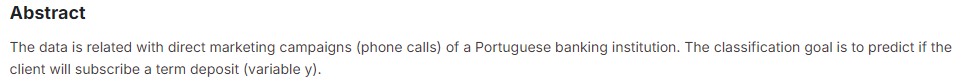

Описание задачи: Решить задачу определения мошеннических транзакций в банковских
операциях, используя логистическую регрессию с техникой регуляризации. В этой задаче
предполагается работа с крупным набором данных, а также решение проблемы
несбалансированных классов, так как мошеннические транзакции составляют только малую
часть от общего числа транзакций.

# 1. Загрузка данных:

In [1]:
!kaggle datasets download -d alexkataev/bank-marketing-data-set
!unzip bank-marketing-data-set.zip

Dataset URL: https://www.kaggle.com/datasets/alexkataev/bank-marketing-data-set
License(s): other
  0% 0.00/393k [00:00<?, ?B/s]
100% 393k/393k [00:00<00:00, 67.2MB/s]
Archive:  bank-marketing-data-set.zip
  inflating: bank-additional-full.csv  
  inflating: bank-additional-names.txt  


# 2. Предобработка данных:

**Изучение данных и их предобработка**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bank_full = pd.read_csv('bank-additional-full.csv', sep = ';') # sep метод табуляции
bank_full.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
bank_full.nunique()

,0
age,78
job,12
marital,4
education,8
default,3
housing,3
loan,3
contact,2
month,10
day_of_week,5


   Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   # related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone")
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   # other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   # social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  20 - nr.employed: number of employees - quarterly indicator (numeric)

   # Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [5]:
bank_full.shape

(41188, 21)

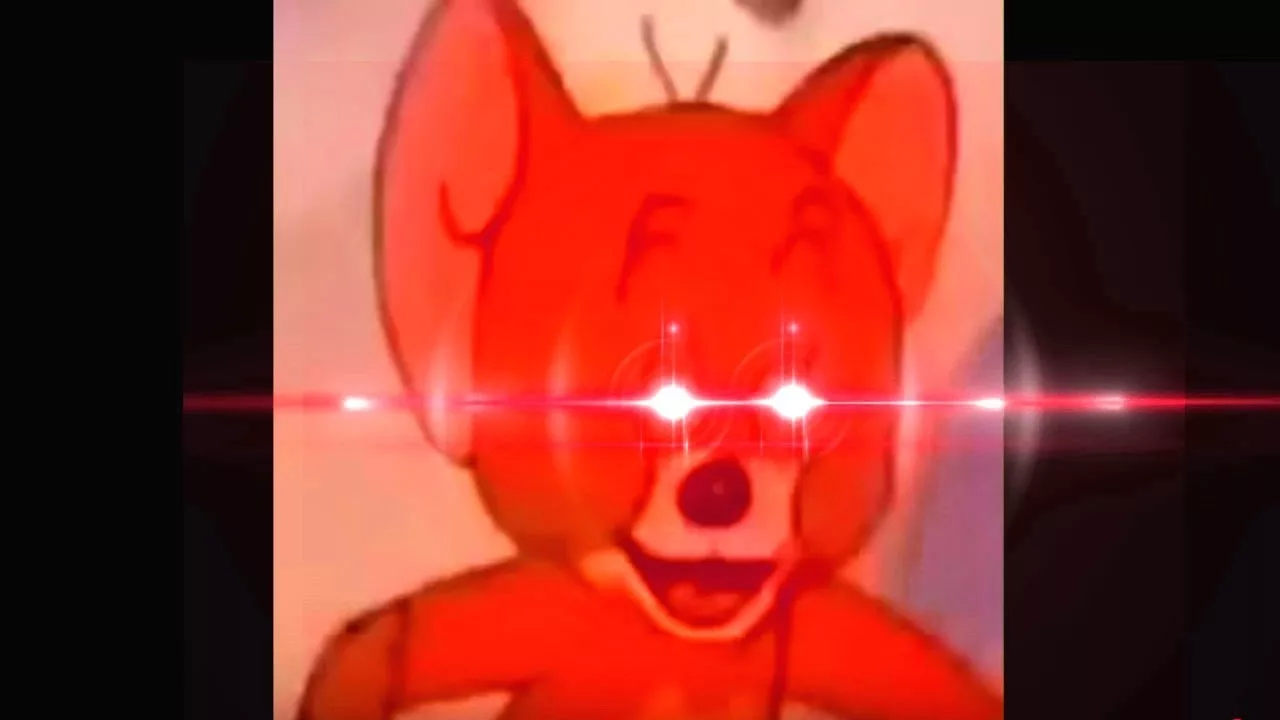

41188 клиентов и 21 признак



**обработка пропущенных значений**

Так как у нас 41188 данных, мы можем просто удалить пустые

In [6]:
missing_values = bank_full.isnull().sum()
print(missing_values)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


**масштабирование, нормализация**

In [7]:
bank_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [12]:
from sklearn.preprocessing import minmax_scale, LabelEncoder

encode = LabelEncoder()

columns = bank_full.columns

for i in columns:
  if bank_full[i].dtype == object:
    bank_full[i] = encode.fit_transform(bank_full[i])

In [13]:
bank_full.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [60]:
bank_new = minmax_scale(bank_full)

In [61]:
bank_new.shape

(41188, 21)

**разделение данных на обучающий и тестовый
наборы.**

перемешиваем данные через randomstate, так как данные кажутся мне отсортированными по убыванию. И на последок проверю не будет ли переобучения из-за количества доминирующего класса

In [62]:
from collections import Counter

Counter(bank_new[:,-1])

Counter({0.0: 36548, 1.0: 4640})

In [50]:
np.sum(bank_new[:,-1] == 0)

36548

In [67]:
for i in range(bank_new.shape[0]):
  if np.sum(bank_new[:,-1] == 0) == 4640:
    print('Success')
    break
  if bank_new[i,-1] == 0:
    bank_new = np.delete(bank_new, i, 0)

Success


In [68]:
Counter(bank_new[:,-1])

Counter({0.0: 4640, 1.0: 4640})

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bank_new[:,:-1], bank_new[:,-1], test_size=0.25, random_state=39)

L1-регуляризация добавляет к функции потерь штраф, пропорциональный абсолютному значению весов модели. Этот штраф приводит к тому, что некоторые веса могут стать равными нулю, что эффективно исключает соответствующие признаки из модели. L1-регуляризация может быть полезна, когда у нас есть много признаков, и мы хотим выбрать наиболее важные из них.

L2-регуляризация добавляет к функции потерь штраф, пропорциональный квадрату весов модели. Этот штраф приводит к тому, что веса модели будут иметь более маленькие значения, чем без регуляризации. L2-регуляризация может быть полезна, когда у нас есть много признаков, и мы хотим избежать переобучения модели.

In [70]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', C=(1.0))

logreg.fit(X_train, y_train)

LogisticRegression()

In [71]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-3)

sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss')

In [72]:
pred = sgd.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, pred)

precision = precision_score(y_test, pred)

recall = recall_score(y_test, pred)

f1 = f1_score(y_test, pred)

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}')

accuracy: 0.8633620689655173
precision: 0.862521891418564
recall: 0.8602620087336245
f1: 0.8613904678618277


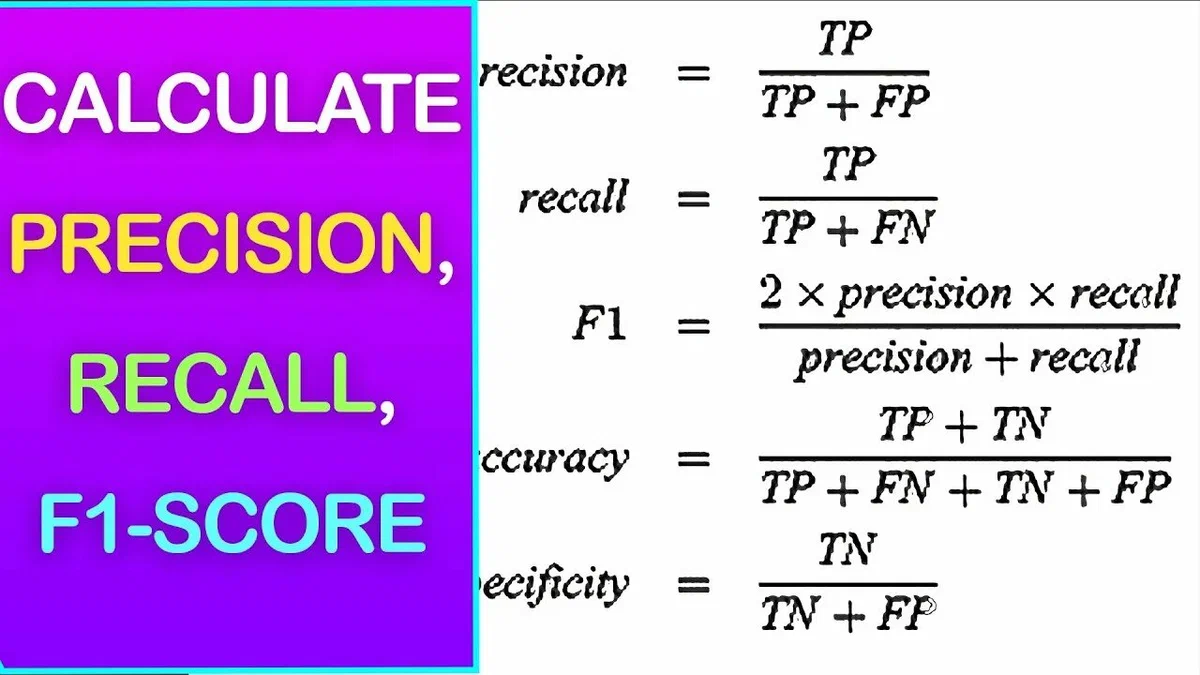

In [74]:
y_pred_proba = sgd.predict_proba(X_test)

In [75]:
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(auc_roc)

0.9321676112608008


AUC-ROC полезная метрика для оценки производительности модели на несбалансированных данных, так как она не зависит от порога классификации и может быть интерпретирована как вероятность того, что случайно выбранный положительный пример будет иметь более высокую оценку модели, чем случайно выбранный отрицательный пример.

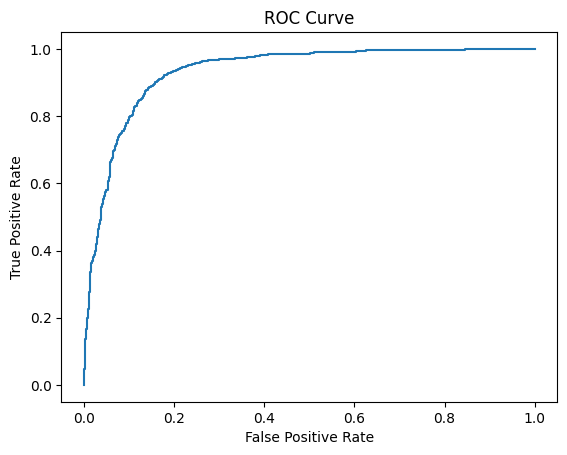

In [76]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [77]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority') # синтетические примеры

X_res, y_res = smote.fit_resample(X_train, y_train)

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('sgd', SGDClassifier())
])

param_grid = {
    'sgd__loss': ['log_loss'],
    'sgd__penalty': ['l2','l1'],
    'sgd__max_iter': [1000,500,100],
    'sgd__tol': [1e-3, 1e-5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_res,y_res)

print(f'Best params:{grid_search.best_params_}\n best f1-score:{grid_search.best_score_}')

Best params:{'sgd__loss': 'log_loss', 'sgd__max_iter': 500, 'sgd__penalty': 'l1', 'sgd__tol': 0.001}
 best f1-score:0.8659700017522421


In [79]:
best_models = grid_search.best_estimator_
pred = best_models.predict(X_test)

accuracy = accuracy_score(y_test, pred)

precision = precision_score(y_test, pred)

recall = recall_score(y_test, pred)

f1 = f1_score(y_test, pred)

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}')

accuracy: 0.8616379310344827
precision: 0.8601398601398601
recall: 0.8593886462882097
f1: 0.8597640891218873


In [80]:
y_pred_proba = best_models.predict_proba(X_test)

In [81]:
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(auc_roc)

0.9345550497073307


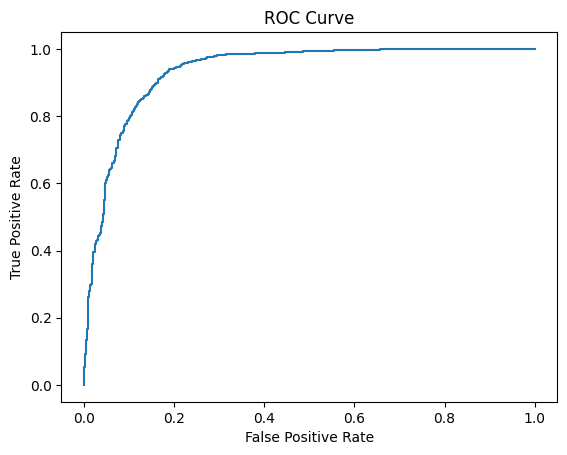

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

pipeline = Pipeline([
    ('lr', LogisticRegression())
])

param_grid = {
    'lr__penalty': ['l2'],
    'lr__tol': [1e-3,1e-5],
    'lr__C': [1.0, 2.5, 12],
    'lr__max_iter': [2000, 5000]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_res,y_res)

print(f'Best params:{grid_search.best_params_}\nbest f1-score:{grid_search.best_score_}')

best_models = grid_search.best_estimator_
pred = best_models.predict(X_test)

accuracy = accuracy_score(y_test, pred)

precision = precision_score(y_test, pred)

recall = recall_score(y_test, pred)

f1 = f1_score(y_test, pred)

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}')

Best params:{'lr__C': 12, 'lr__max_iter': 2000, 'lr__penalty': 'l2', 'lr__tol': 0.001}
best f1-score:0.8535316545222231
accuracy: 0.8629310344827587
precision: 0.8662533215234721
recall: 0.8541484716157205
f1: 0.8601583113456465


In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

pipeline = Pipeline([
    ('clf', GradientBoostingClassifier())
])

param_grid = {
    'clf__n_estimators': [100, 250],
    'clf__learning_rate': [1e-3,0.1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1')
grid_search.fit(X_res,y_res)

print(f'Best params:{grid_search.best_params_}\nbest f1-score:{grid_search.best_score_}')

best_models = grid_search.best_estimator_
pred = best_models.predict(X_test)

accuracy = accuracy_score(y_test, pred)

precision = precision_score(y_test, pred)

recall = recall_score(y_test, pred)

f1 = f1_score(y_test, pred)

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}')

Best params:{'clf__learning_rate': 0.1, 'clf__n_estimators': 250}
best f1-score:0.896257131198067
accuracy: 0.8922413793103449
precision: 0.8751047778709137
recall: 0.9117903930131004
f1: 0.893071000855432


In [85]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4, 5, 14]
}

grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring='f1')
grid_search.fit(X_res,y_res)

print(f'Best_params: {grid_search.best_params_}\nBest f1-score:{grid_search.best_score_}')

best_models = grid_search.best_estimator_
pred = best_models.predict(X_test)

accuracy = accuracy_score(y_test, pred)

precision = precision_score(y_test, pred)

recall = recall_score(y_test, pred)

f1 = f1_score(y_test, pred)

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}')

Best_params: {'max_depth': 14, 'n_estimators': 100}
Best f1-score:0.8971182237013883
accuracy: 0.8935344827586207
precision: 0.8716887417218543
recall: 0.9196506550218341
f1: 0.8950276243093923


# Итоги

До переобучения:

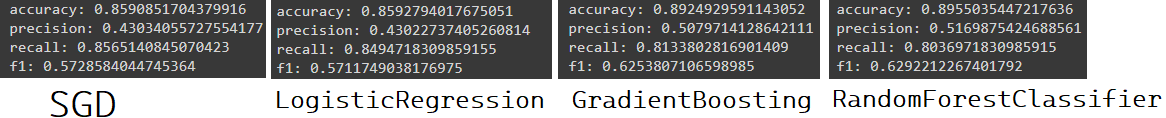

После удаления лишних

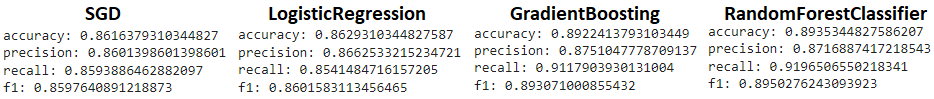

**LogisticRegression**

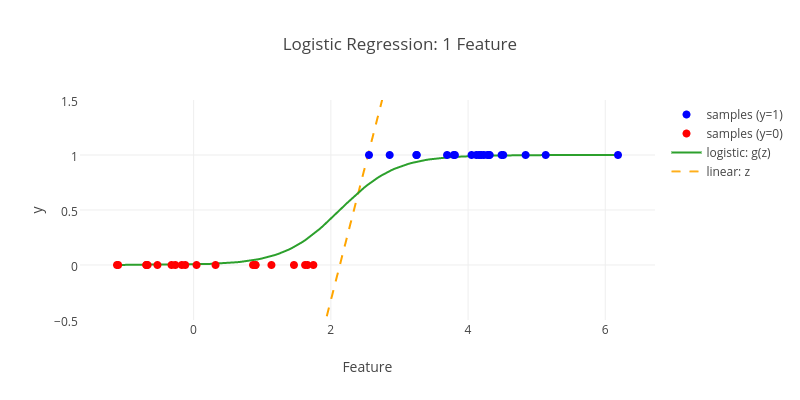

**RandomForestClassifier**

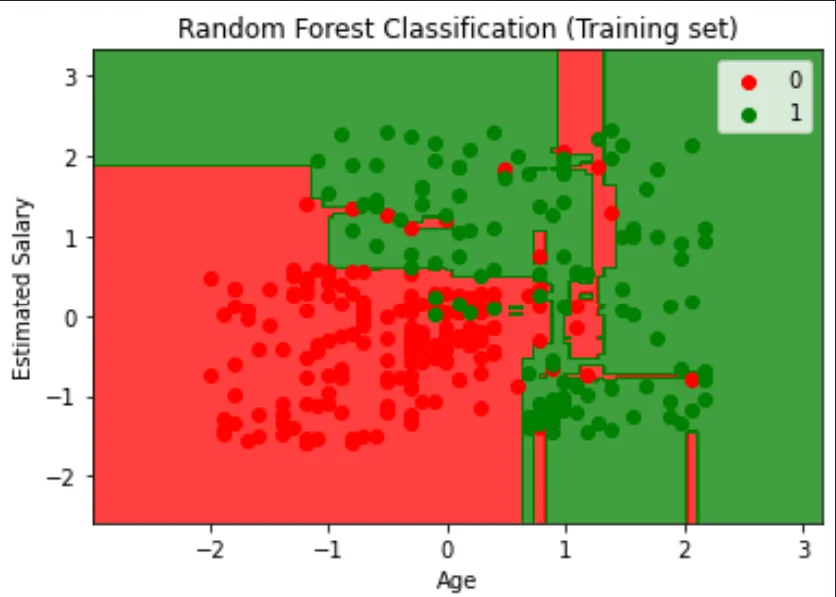

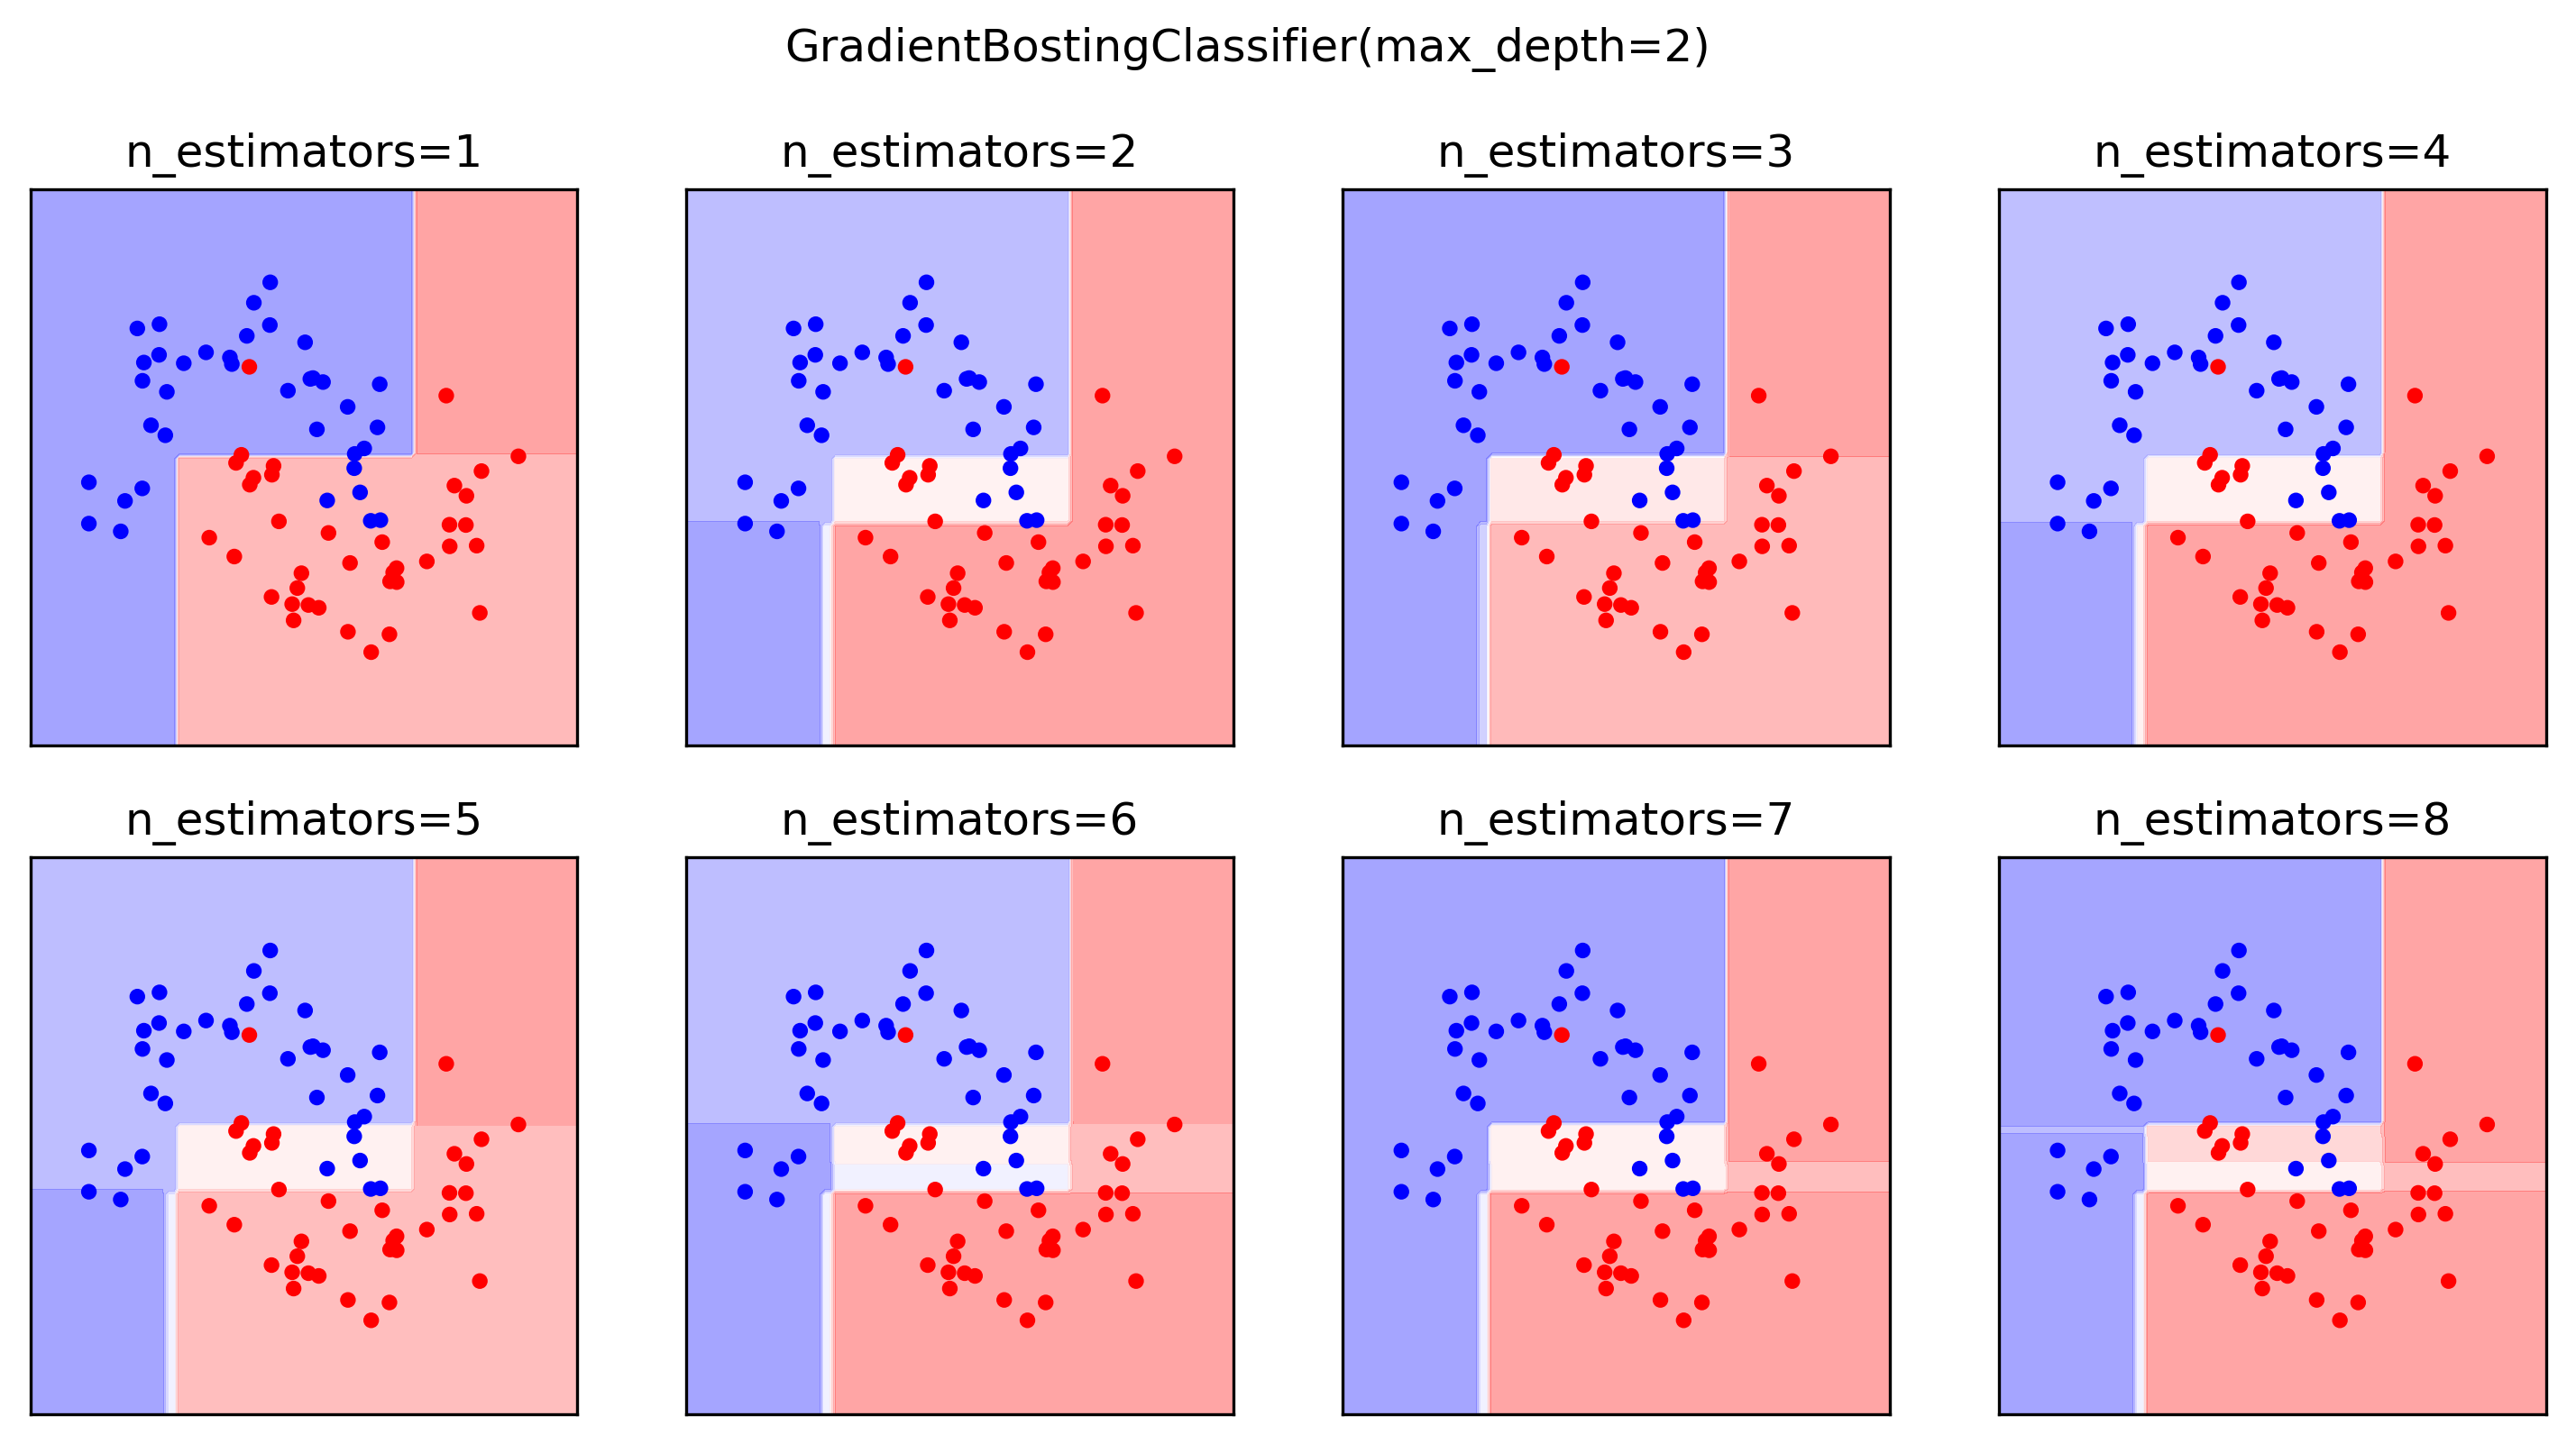



**SGD**

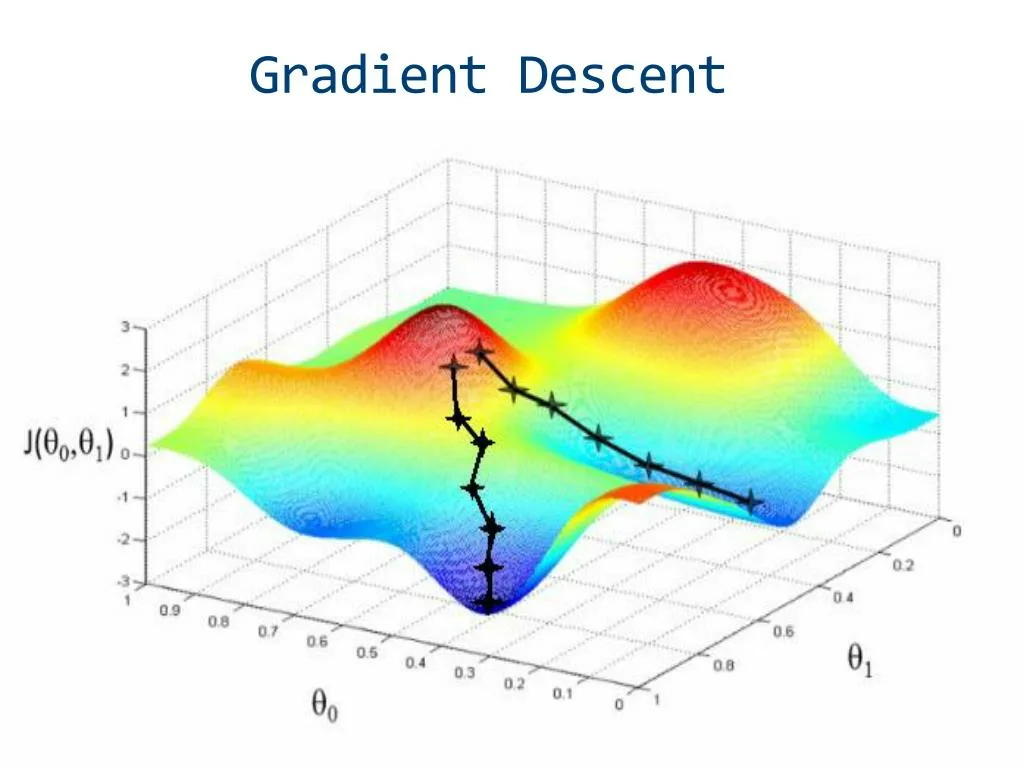

Случайный лес и градиентный бустинг - это методы ансамблевого машинного обучения, которые строят множество деревьев решений и объединяют их для получения более точной и стабильной модели. Случайный лес строит деревья решений на случайных подвыборках признаков и объединяет их голосованием, в то время как градиентный бустинг строит деревья решений последовательно, каждое из которых корректирует ошибки предыдущего дерева.